# Predict direction of market using past information

## Use returns of Brent crude oil in D-1,2,3,4,5 and number of moving average to predict if D day return is UP or DOWN

Traders usually like to ask the 1 million dollar question : Is the market going UP or DOWN today ?

The analyst gathers all arguments possible to answer but in fact he will give the most probable situation. Sometimes if market has strong move during one day, it might correct the day after, put another way we have higher chance of market going down after a day up, vice e versa. In the oil markets for example, the weekly stock reports in US are released 3 times during the week : 1st by poll of analysts on Monday, then API on Tuesday and finally Thursday from the governemental agency EIA. We know that markets nowadays believe more information coming from the latter institution, and if analysts and API miss estimation, we might have opposite direction in market too.

Even if this is not true it is interesting to study the correlation of past returns and impact on next day return for a commodity asset class.

The motivation for this work comes the need to have a 1st opinion in the morning where the market should go, and express it in term of probability.

I have based my work with a book "An Introduction to Statistical Learning, with R" from Gareth James , Daniela Witten, Trevor Hastie , Robert Tibshirani

I have used python libraries scikit learn, stasmodels and matplotlib.

A) Correlation study

B) Logistic regression model

C) Cross Validation with k-fold method

D) Possible extension LDA, QDA and k NN


In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols


C:\Users\BQUIDET\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## A) Prepare variables

In [3]:
# we read data from csv
brent = pd.read_csv('dataBrent.csv',sep=',', parse_dates=[0], index_col=0,infer_datetime_format=True)
brent = brent.fillna(float('nan'))

# We take first 6 lines out of sample and convert all data into numeric
brent = brent.iloc[6::]
brent.index.names = ['Date']
brent = brent.apply(pd.to_numeric)
brent.index = pd.to_datetime(brent.index)

# We create the return column
brent_rets = brent
brent_rets['rets'] = brent['CO1 Comdty'].pct_change()

# Let's create all lag in a new column
for i in range(5):
    brent_rets['lag'+'{}'.format(i+1)]=brent_rets['rets'].shift(i+1)

# Create check function, we won't include 0 in the UP market as we consider
def UporDown(x):
    if x > 0:
        return 1
    elif x <= 0:
        return 0

ma_day = [5,10,20,50,100,200]
#volumeMA = DataFrame(databrute.sort_index())
for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    brent_rets[column_name]= brent_rets['CO1 Comdty'].rolling(ma).mean()

    

brent_rets['Direction'] = brent_rets['rets'].apply(UporDown)
# Now we create variable with the number of MA above and below market price by taking the sign  
# of the difference Price - MA
brent_rets['numberMAabove'] = np.sign(brent_rets['MA for 200 days'] + brent_rets['CO1 Comdty'])+np.sign(brent_rets['MA for 100 days']-brent_rets['CO1 Comdty'] ) +np.sign(brent_rets['MA for 50 days']-brent_rets['CO1 Comdty'])+np.sign(brent_rets['MA for 20 days']-brent_rets['CO1 Comdty'])+np.sign(brent_rets['MA for 10 days']-brent_rets['CO1 Comdty'])+np.sign(brent_rets['MA for 5 days']-brent_rets['CO1 Comdty']) 


C:\Users\BQUIDET\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sign


In [4]:
# Now we have to drop the MA and take data from 1996 in order to have all value for the new variable numberMAabove
brent_rets = brent_rets.drop(['MA for 5 days','MA for 10 days','MA for 20 days','MA for 50 days','MA for 100 days','MA for 200 days','FUT_AGGTE_VOL'],axis=1)

brent_rets = brent_rets[brent_rets.index>'1996-01-01']
brent_rets.tail()

,CO1 Comdty,rets,lag1,lag2,lag3,lag4,lag5,Direction,numberMAabove
Date,,,,,,,,,
2017-12-18,63.41,0.002847,-0.001264,0.013933,-0.014209,-0.020869,0.020347,1.0,-4.0
2017-12-19,63.80,0.006150,0.002847,-0.001264,0.013933,-0.014209,-0.020869,1.0,-4.0
2017-12-20,64.56,0.011912,0.006150,0.002847,-0.001264,0.013933,-0.014209,1.0,-4.0
2017-12-21,64.90,0.005266,0.011912,0.006150,0.002847,-0.001264,0.013933,1.0,-4.0
2017-12-22,65.25,0.005393,0.005266,0.011912,0.006150,0.002847,-0.001264,1.0,-4.0


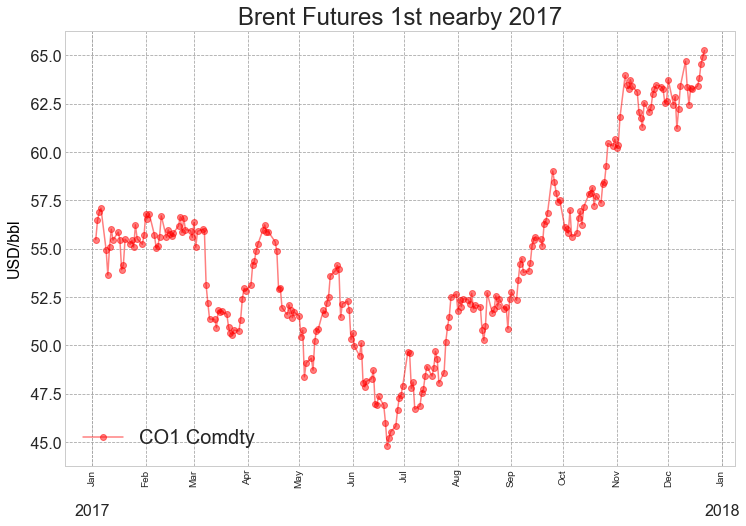

In [6]:
from datetime import datetime
import matplotlib.dates as mdates
# Let's plot Brent price to understand what is happening in 2017


years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n\n%Y') 

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylabel('USD/bbl', color='black',size=16)
ax.grid(which='both', color='0.65',linestyle='--')
temp = brent_rets[brent_rets.index>'2017-01-01']
ax.plot(temp.index, temp['CO1 Comdty'],'-bo', color='r',alpha=0.5)
vals1 = ax.get_yticks()
ax.set_yticklabels(['{:5,.1f}'.format(x) for x in vals1])
ax.tick_params(labelsize=16)

# Let's put Dates in better format with Year and Month
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)


ax.legend(loc='lower left',prop={'size':20})

plt.title("Brent Futures 1st nearby 2017",size=24);

 
 We can see a 1H 2017 is a down trend with a low in June. 
 After we have an uptrend until December, we will use this set to validate the modele trained from 1995 to 2016,
 as it reflects the most recent behavior of crude oil market.
 
 Market saw stocks rising at the beggining of 2017, with agreement of OPEC in Nov 2016 to cut production at 32.5mio bbls, agreement which excluded Nigeria and Libya. Market was disappointed as commitment of countries was not at expectation and de facto some countries did not comply at 100%.
 
 This coincides with expectation of OPEC meeting on Nov 30 to extend production cut into 2018 
 Global oil stocks are decreasing and expected to be below 5 years moving average in March 2018
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

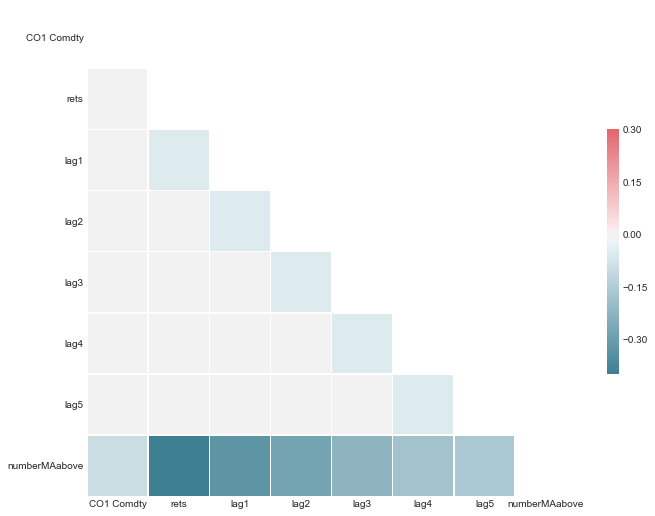

In [7]:
# Let's see correlation btw lag returns

test = brent_rets.copy()
test = test.drop('Direction',1)
#test = test.drop('Weekday',1)


# Compute the correlation matrix
corr = test.dropna().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});


We can see clearly that number of moving averages has a negative correlation with return of Brent price.
This goes against the naive opinion which states that when prices trend above or under its moving average,
it tends to correct and revert toward moving average.

In [8]:
brent_rets.describe()

,CO1 Comdty,rets,lag1,lag2,lag3,lag4,lag5,Direction,numberMAabove
count,5618.000000,5618.000000,5618.000000,5618.000000,5618.000000,5618.000000,5618.000000,5618.000000,4679.000000
mean,56.434751,0.000468,0.000468,0.000466,0.000469,0.000468,0.000467,0.512104,0.545416
std,33.843335,0.022010,0.022010,0.022010,0.022013,0.022013,0.022013,0.499898,3.820024
min,9.640000,-0.134434,-0.134434,-0.134434,-0.134434,-0.134434,-0.134434,0.000000,-4.000000
25%,25.942500,-0.011346,-0.011346,-0.011346,-0.011346,-0.011346,-0.011346,0.000000,-4.000000
50%,50.820000,0.000747,0.000747,0.000742,0.000742,0.000742,0.000731,1.000000,0.000000
75%,78.910000,0.011926,0.011926,0.011926,0.011938,0.011938,0.011938,1.000000,4.000000
max,146.080000,0.137670,0.137670,0.137670,0.137670,0.137670,0.137670,1.000000,6.000000



# B) Logistic regression

In [9]:
# Create new DataFrames for the Categorical Variables

# Set X as new DataFrame without the Direction columns nor the Y target
X = brent_rets.drop(['Direction','CO1 Comdty','rets'],axis=1)

#X = X.iloc[6::]
X.index = Series(range(0,len(X.index)))
X = X.fillna(0)


AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\BQUIDET\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


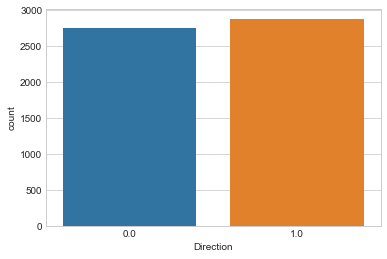

In [12]:

# Set Y as Target class, returns
Y = brent_rets.Direction

# Preview
Y.head()
Y = Y.convert_objects(convert_numeric=True)


Y = Y.fillna(0)

Y.index = Series(range(0,len(Y.index)))

print(sns.countplot(Y));

# Flatten array
Y = np.ravel(Y);


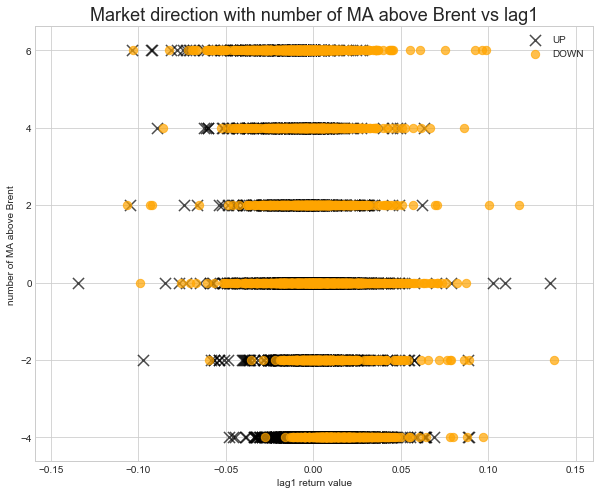

In [13]:
# let's plot direction of the market with lag1 et lag3 in x and y axis
import matplotlib.cm as cm
import matplotlib.colors as colors

plt.figure(figsize=(10,8))
#fig, ax = plt.subplots(figsize=(12,8))
#leg = {'1':'Up','0':'Down'}
#ax.scatter(X['lag1'],X['numberMAabove'],c=Y,label=leg)

plt.scatter(X['lag1'][Y == 1], 
            # attacker size in year 298 as the y axis
            X['numberMAabove'][Y == 1], 
            # the marker as
            marker='x', 
            # the color
            color='black',
            # the alpha
            alpha=0.7,
            # with size
            s = 124,
            # labelled this
            label='UP')

plt.scatter(X['lag1'][Y == 0], X['numberMAabove'][Y == 0], 
            # the marker as
            marker='o', 
            # the color
            color='orange',
            # the alpha
            alpha=0.7,
            # with size
            s = 70,
            # labelled this
            label='DOWN')

# Chart title
plt.title('Market direction with number of MA above Brent vs lag1',size=18)

# y label
plt.ylabel('number of MA above Brent')

# x label
plt.xlabel('lag1 return value')

# and a legend
plt.legend(loc='upper right')
plt.show()

We can see that when they are 6 moving averages above price of Brent, we don't really see that market went UP or DOWN with specific number of MA above or below current Price.

In [19]:
# Use statsmodel to summarise and before doing machine learning separation btw train and test sample

import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.603828
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5628
Method:                           MLE   Df Model:                            5
Date:                Fri, 29 Jun 2018   Pseudo R-squ.:                  0.1286
Time:                        13:14:49   Log-Likelihood:                -3402.0
converged:                       True   LL-Null:                       -3903.9
                                        LLR p-value:                8.644e-215
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
lag1            -22.3037      1.513    -14.741      0.000     -25.269     -19.338
lag2            -14.

We see different things here:

- lag1,2,3,4,5 has all negative coefficient, lag1 and lag2 have bigger coefficient than lag3,4 and 5

- numberMAabove is significant in the model as we can see the biggest z value, we can see though that the coefficient is negative, meaning that the more MAs above price will tend to make direction of market down. As z-value are computed as the test statistic for the hypothesis test that the true corresponding regression cofficient equals 0. As lag1,2 and numberMAabove z-values are all outside the confidence inteval at 95%, we can reject H0 hypothesis with 95% conficence and keep those variables

- lag3,4 z-values are debatables but we will keep them as we want to keep returns over 1 week past 

In [18]:
# let's run the model with only 1 variable in order to see that there are no counfounding for the numberMAabove 
# variable. 
XX = X.copy(0)
YY = Y.copy()
XX = XX.drop(['lag1','lag2','lag3','lag4','lag5',],axis=1)

import statsmodels.api as sm
logit_model=sm.Logit(YY,XX)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.634077
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5633
Method:                           MLE   Df Model:                            0
Date:                Fri, 29 Jun 2018   Pseudo R-squ.:                 0.08492
Time:                        13:14:36   Log-Likelihood:                -3572.4
converged:                       True   LL-Null:                       -3903.9
                                        LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
numberMAabove    -0.2082      0.009    -24.239      0.000      -0.225      -0.191


The cofficient of numberMAabove variable is still negative, so we can confirm it has negative impact on the logit
or the odds of market going UP

In [21]:
# Now we fit the model to logistic by using Maximum of Likelyhood to determine the coefficient to use in the 
# logit function

# Create LogisticRegression model
log_model = LogisticRegression()

# Fit our data
log_model.fit(X,Y)

# Check our accuracy
print(log_model.score(X,Y))


0.6450124245651402


              prob assoc with model
xaxis                              
6.661338e-16               0.740848


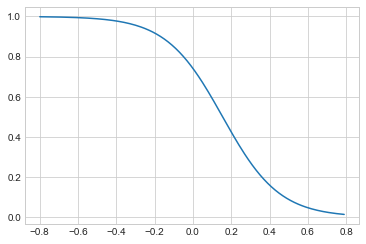

In [25]:
#let's print the log-odds function using lag1 days possiblity

# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df = DataFrame(dict(zip(X.columns, np.transpose(log_model.coef_))))

xabs = np.arange(-0.8,0.8 , 0.01)

# Let's create empty array with lag1 value in x-axis
ligne = []
# test will be the array with predictions made for a range of different values for lag1 returns
test = []

# We create for loop to fill probability of market direction in y-axis according to lag1
for i in range(len(xabs)):
    ligne.append(np.dot(np.array(log_model.coef_), np.array([xabs[i],brent_rets['rets'][-2], brent_rets['rets'][-3],brent_rets['rets'][-4],brent_rets['rets'][-5],brent_rets['numberMAabove'][-1]])))
    test.append([xabs[i],brent_rets['rets'][-2], brent_rets['rets'][-3],brent_rets['rets'][-4],brent_rets['rets'][-5],brent_rets['numberMAabove'][-1]])

d = {'xaxis': xabs, 'prob assoc with model': log_model.predict_proba(test)[:,1]}
df = pd.DataFrame(data=d)
df.index = df['xaxis']
df = df.drop(['xaxis'],axis=1)
plt.plot(xabs,log_model.predict_proba(test)[:,1])

#print df.loc[df['prob assoc with model'] in [-0.07:-0.06]]
print(df.loc[0:0.01])

 We see that model is very narrow around 70 to 80% probability range. outside those levels we have returns for higher than 20%, which is not realistic for market situation in Brent crude oil.

       prob assoc with number of MA above and below
xaxis                                              
0                                          0.514437


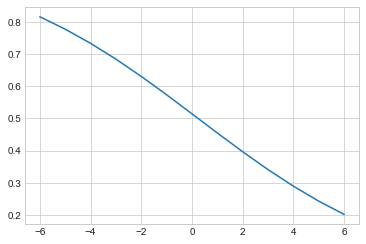

In [26]:
# Use zip to bring the column names and the np.transpose function to bring together the coefficients from the model
coeff_df = DataFrame(dict(zip(X.columns, np.transpose(log_model.coef_))))

xabs = np.arange(-6,7,1)
# Let's create empty array with lag1 value in x-axis
ligne = []
# test will be the array with predictions made for a range of different values for lag1 returns
test = []

# We create for loop to fill probability of market direction in y-axis according to lag1
for i in range(len(xabs)):
    ligne.append(np.dot(np.array(log_model.coef_), np.array([xabs[i],brent_rets['rets'][-2], brent_rets['rets'][-3],brent_rets['rets'][-4],brent_rets['rets'][-5],xabs[i]])))
    test.append([brent_rets['rets'][-1],brent_rets['rets'][-2], brent_rets['rets'][-3],brent_rets['rets'][-4],brent_rets['rets'][-5],xabs[i]])

d = {'xaxis': xabs, 'prob assoc with number of MA above and below': log_model.predict_proba(test)[:,1]}
df = pd.DataFrame(data=d)
df.index = df['xaxis']
df = df.drop(['xaxis'],axis=1)
plt.plot(xabs,log_model.predict_proba(test)[:,1])

#print df.loc[df['prob assoc with model'] in [-0.07:-0.06]]
print(df.loc[0:0.01])

We can see that according to the number of MA above or below the probability for market of going up or down 
ranges from 20% in situation where Brent is overbought with 6 MA on top and it needs to continue to drift higher. 
On the otherside, when market is oversold, with 6 moving averages above, we see the probability of going uponly at 80%.


In [27]:
# Now let's calculate the probability that market will go up on Monday

last5days = [brent_rets['rets'][-1],brent_rets['rets'][-2], brent_rets['rets'][-3],brent_rets['rets'][-4],brent_rets['rets'][-5],brent_rets['numberMAabove'][-1]]
last5days = np.array(last5days)
last5days = last5days.reshape(1,-1)
log_model.predict_proba(last5days)

array([[0.26622882, 0.73377118]])

In [28]:
log_model.classes_

array([0., 1.])

We conclude that direction of market will go up on Tuesday 27th of December, as probabiity is 73.3% 
and superior at 50%

Now let's split data with training and test in order to calculate an error sample if we consider that all probability above 50% will be UPside market

In [29]:
#let's train our data before 2017
X_train = brent_rets.drop(['Direction','CO1 Comdty','rets'],axis=1)
#X_train = X_train.iloc[6::]
X_train = X_train[X_train.index<'2017-01-01']
X_train.index = Series(range(0,len(X_train.index)))
X_train = X_train.fillna(0)

# Now the Direction
Y_train = brent_rets[brent_rets.index<'2017-01-01'].Direction
#Y_train = Y_train.iloc[6::]
Y_train = Y_train.fillna(0)
Y_train.index = Series(range(0,len(Y_train.index)))
# Flatten array
Y_train = np.ravel(Y_train)


# Now let's do the test set
X_test = brent_rets.drop(['Direction','CO1 Comdty','rets'],axis=1)
X_test = X_test[X_test.index>='2017-01-01']
X_test.index = Series(range(0,len(X_test.index)))
X_test = X_test.fillna(0)

# Now the Direction
Y_test = brent_rets[brent_rets.index>='2017-01-01'].Direction
Y_test = Y_test.fillna(0)
Y_test.index = Series(range(0,len(Y_test.index)))
# Flatten array
Y_test = np.ravel(Y_test)


# Make a new log_model
log_model2 = LogisticRegression()

# Now fit the new model
log_model2.fit(X_train, Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
# Predict the classes of the testing data set
class_predict = log_model2.predict(X_test)

# Compare the predicted classes to the actual test classes
print(metrics.accuracy_score(Y_test,class_predict))

0.6403162055335968


It looks like we have a accuracy rate better than the naive approach in 2017 returns , at 64% we can predict that market will go UP or DOWN, which is not bad. Let's see what this model gives for Tuesday 27th 

In [32]:
log_model2.predict_proba(last5days)

array([[0.26646324, 0.73353676]])

So we have a 73.3% chance that market will go UP on December 27th. ( In reality it went down on that day ;) ! )

In [33]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(Y_test,class_predict).ravel()
print (tn, fp, fn, tp)

confusion_matrix(Y_test,class_predict)

59 51 40 103


array([[ 59,  51],
       [ 40, 103]], dtype=int64)

 total 253 returns over the year 2017
 
 the logistic model made 54 incorrect prediction when market was going down and it predicted to go up. This happens at the 1H of 2017, when market was trending lower from 57 to 45 $ a barrel, but we notice that market was correcting more after it made moves on the downside.
 
 the logistic model made 38 incorrect prediction when market was going up and it predicted to go down. The incorrect prediction happened mostly after June 2017 when market was trending up with consecutives days up. 
 
 The Recall for this model is TP/(TP+FN) = 103/143 = 0.73
 
 The precision for this model is TP/(TP+FP) = 105/159 = 0.66
 
 The specificity for this model is TN/(TN+FP) = 59 / 110 = 0.53
 
 The ROC for this model is RECALL/ SPECIFICITY = 0.73 / ( 0.53) = 1.37
 
 When data is highly skewed the recall-precision give a better picture of the model performance = 1.106
 

We have here good predictions for recall or number of positive model catched.
Nonetheless the specificity is st low and show we have catched only 53% of the negative values.

# Cross-validation with k-fold methods

Let's split the initial sample X into k samples : we will take 40 samples as we want 1 sample per semester

we use test sample as first simple and run 40 times the operation to evaluate the accuracy score, each set has 
a different test set



In [34]:
from sklearn.model_selection import KFold

# We create empty array which will store the accuracy of estimation
dtemp = []

# We use original data and prepare it
rets = brent_rets
#rets = rets.iloc[6::]
rets = rets.fillna(0)
rets.index = Series(range(0,len(rets.index)))
dire = np.array(rets.Direction)
rets = np.array(rets.drop(['Direction','CO1 Comdty','rets'],axis=1))

# We create 40 different sets from original data and run a k-fold method to Cross validate
kf = KFold(n_splits=40)

# We loop into the 39 different training set to calculate accurace with validation set
for train, test in kf.split(rets):
    # we create each train and test sets using k-fold method and name corresponding data
    X_train, X_test, y_train, y_test = rets[train], rets[test], dire[train], dire[test]
    
    # we fit the model of the train data for each 39 training set
    log_model3 = LogisticRegression()
    log_model3.fit(X_train, y_train)
    
    # we predict the direction with each training set
    class_predict = log_model3.predict(X_test)

    # we calculate the accuracy of prediction with validation set and store the accuracy score in a new variable
    dtemp.append(metrics.accuracy_score(y_test,class_predict))


The cross validation model gives a mean accuracy of 0.6446783181357649


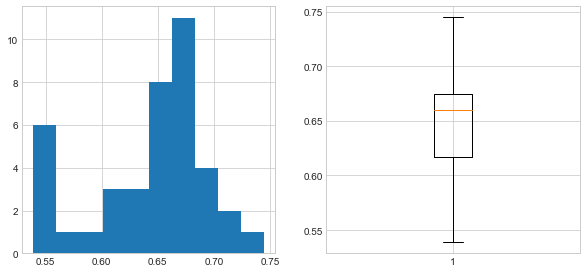

In [37]:
print ("The cross validation model gives a mean accuracy of %s" %np.array(dtemp).mean())

fig, ax = plt.subplots(1,2,figsize=(10, 10))

ax1 = plt.subplot(221)
plt.hist(dtemp);

ax2 = plt.subplot(222)
plt.boxplot(dtemp);


 The K-fold CV gives us a lower accuracy rate of the model than the accuracy of 2017 test set. 

Let's see what period gave a prediction accuracy of 55%


In [39]:
outliers = []

for train, test in kf.split(rets):
    # we create each train and test sets using k-fold method and name corresponding data
    X_train, X_test, y_train, y_test = rets[train], rets[test], dire[train], dire[test]
    
    # we fit the model of the train data for each 39 training set
    log_model3 = LogisticRegression()
    log_model3.fit(X_train, y_train)
    
    # we predict the direction with each training set
    class_predict = log_model3.predict(X_test)
    
    if metrics.accuracy_score(y_test,class_predict)<0.55:
        outliers.append(test)
        
df = Series(outliers)

for i in range(len(df)):
    date1=min(brent_rets.iloc[min(df[i]):max(df[i])].index)
    date2=max(brent_rets.iloc[min(df[i]):max(df[i])].index)
    print(" the incices of the test period for which accuracy rate was below 55pct is %s, %s " %(date1.date(),date2.date()))
    #print " the incices of the test period for which accuracy rate was below 55pct is %s" %date1
#df.to_csv('trainset.csv')

 the incices of the test period for which accuracy rate was below 55pct is 2001-01-10, 2001-07-25 
 the incices of the test period for which accuracy rate was below 55pct is 2002-02-11, 2002-08-28 
 the incices of the test period for which accuracy rate was below 55pct is 2003-03-17, 2003-10-02 


We have three different periods during which we see very low accuracy rate if we train the model out of those times. 
It is not enough to conclude something from it though, as it was not a particular time such as 2008 crisis

# Let's check with Naive Bays model


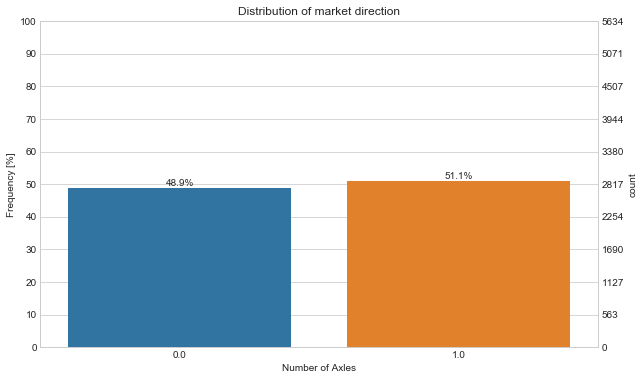

In [56]:
import matplotlib

DataFrame(rets)

def distri(dire):
    plt.figure(figsize=(10,6))

    ax = sns.countplot(dire)

    ncount = len(dire)

    plt.title('Distribution of market direction')
    plt.xlabel('Number of Axles')

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    

distri(dire)

# 1] Create a pipeline for the logistic model

In [72]:
from sklearn.pipeline import Pipeline, FeatureUnion

full_pipeline = Pipeline([
    ("logistic", LogisticRegression()),
])

full_pipeline.fit(rets,dire)

full_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'logistic', 'logistic__C', 'logistic__class_weight', 'logistic__dual', 'logistic__fit_intercept', 'logistic__intercept_scaling', 'logistic__max_iter', 'logistic__multi_class', 'logistic__n_jobs', 'logistic__penalty', 'logistic__random_state', 'logistic__solver', 'logistic__tol', 'logistic__verbose', 'logistic__warm_start'])

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Let's do a random search to get the best param
param_distribs = {
        'logistic__C': [1,5,10,20,50],
        'logistic__fit_intercept': [True, False],
        'logistic__class_weight': ['balanced']
    }

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=6, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(rets, dire)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=6, n_jobs=4,
          param_distributions={'logistic__C': [1, 5, 10, 20, 50], 'logistic__fit_intercept': [True, False], 'logistic__class_weight': ['balanced']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [75]:
#display_scores and best parameters

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", np.sqrt(-rnd_search.cv_results_['mean_test_score']).mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.5881627260046924
Mean: 0.591890950580077
Standard deviation: 0.0
Best params: {'logistic__fit_intercept': False, 'logistic__class_weight': 'balanced', 'logistic__C': 20}


In [76]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.57581272 0.58041316 0.66976232 0.66177282 0.57888374 0.59100827
 0.56020513 0.5737434  0.57529197 0.5875336 ]
rmse(mean, std): (0.596534, 0.211399)
training rmse:  0.5958083378359686


# 2] Create pipeline for Naive Bays model similarly to above 

In [80]:
from sklearn.naive_bayes import BernoulliNB

full_pipeline = Pipeline([
    ("NaiveBays", BernoulliNB()),
])

full_pipeline.fit(rets,dire)

full_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'NaiveBays', 'NaiveBays__alpha', 'NaiveBays__binarize', 'NaiveBays__class_prior', 'NaiveBays__fit_prior'])

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Let's do a random search to get the best param
param_distribs = {
        'NaiveBays__alpha': [0.1, 0.5,1,5,10],
        'NaiveBays__binarize': [None, 1],
        'NaiveBays__fit_prior': [0, 1],
    }

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=6, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(rets, dire)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  23 out of  30 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('NaiveBays', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
          fit_params=None, iid=True, n_iter=6, n_jobs=4,
          param_distributions={'NaiveBays__alpha': [0.1, 0.5, 1, 5, 10], 'NaiveBays__binarize': [None, 1], 'NaiveBays__fit_prior': [0, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [86]:
#display_scores and best parameters

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", np.sqrt(-rnd_search.cv_results_['mean_test_score']).mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.6043858164471356
Mean: 0.6962289095474071
Standard deviation: 0.0
Best params: {'NaiveBays__fit_prior': 1, 'NaiveBays__binarize': 1, 'NaiveBays__alpha': 5}


In [87]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.57888374 0.58041316 0.69317852 0.69827548 0.57117522 0.58345997
 0.56336124 0.57991287 0.581445   0.59505674]
rmse(mean, std): (0.604366, 0.245107)
training rmse:  0.6043858164471356


 => We can see that Naive Bays does slighlty better than logistic model
 
 => Next we will study the Gaussian Discriminant Analysis, by taking the intuition that it is a stronger assumption of the logistic model, when data is behaving more like as a normal distribution ( which can be the case for distribution of stock returns )

# 3] Gaussian discriminant analysis model

In [89]:
# We will use sklearn and Linear Discriminant analysis , which refere to model of Gaussian DA with fixed covariance
# After we will use Quadratique DA in the case of different covariance

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

full_pipeline = Pipeline([
    ("LDA", LinearDiscriminantAnalysis()),
])

full_pipeline.fit(rets,dire)

full_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'LDA', 'LDA__n_components', 'LDA__priors', 'LDA__shrinkage', 'LDA__solver', 'LDA__store_covariance', 'LDA__tol'])

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Let's do a random search to get the best param
param_distribs = {
        'LDA__priors': [None],
        'LDA__solver': ['svd'],
        'LDA__shrinkage': [None],
        'LDA__store_covariance':[True,False]
    }

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=2, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(rets, dire)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]),
          fit_params=None, iid=True, n_iter=2, n_jobs=4,
          param_distributions={'LDA__priors': [None], 'LDA__solver': ['svd'], 'LDA__shrinkage': [None], 'LDA__store_covariance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [110]:
#display_scores and best parameters

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", np.sqrt(-rnd_search.cv_results_['mean_test_score']).mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.5895191568988473
Mean: 0.5895191568988473
Standard deviation: 0.0
Best params: {'LDA__store_covariance': True, 'LDA__solver': 'svd', 'LDA__shrinkage': None, 'LDA__priors': None}


In [111]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.55862039 0.56336124 0.64686916 0.67503612 0.5999409  0.569621
 0.57888374 0.57063366 0.56120105 0.56436277]
rmse(mean, std): (0.590095, 0.216844)
training rmse:  0.5893685965191989


=> The model doesn't do better than logistic model, it maybe a consequence of stronger assumption that both categories behave like a normal distribution

=> Will try the Quadratique DA to compare

#### QDA

In [112]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

full_pipeline = Pipeline([
    ("QDA", QuadraticDiscriminantAnalysis()),
])

full_pipeline.fit(rets,dire)

full_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'QDA', 'QDA__priors', 'QDA__reg_param', 'QDA__store_covariance', 'QDA__store_covariances', 'QDA__tol'])

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Let's do a random search to get the best param
param_distribs = {
        'QDA__priors': [None,[0,1]],
        'QDA__reg_param': [0.1,0.5,1,5,10],
        'QDA__store_covariance': [True,False],
    }

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=2, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(rets, dire)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('QDA', QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001))]),
          fit_params=None, iid=True, n_iter=2, n_jobs=4,
          param_distributions={'QDA__priors': [None, [0, 1]], 'QDA__reg_param': [0.1, 0.5, 1, 5, 10], 'QDA__store_covariance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [114]:
#display_scores and best parameters

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", np.sqrt(-rnd_search.cv_results_['mean_test_score']).mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.6043858164471356
Mean: 0.6594916723072985
Standard deviation: 0.0
Best params: {'QDA__store_covariance': True, 'QDA__reg_param': 0.1, 'QDA__priors': None}


In [115]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.55383896 0.569621   0.64412236 0.66976232 0.59697821 0.58041316
 0.59549133 0.55802142 0.56278413 0.57063366]
rmse(mean, std): (0.591294, 0.211151)
training rmse:  0.5875588626770948


=> It doesn't perform well, so we will not investigate more at the moment

=> If we consider the logic, and as we saw from the plot that returns can not be separated from a linear bound
 maybe if we map those points in higher dimension with kernels, we will be able to get a better separation, so a Support Vector Machine algorithm might be a good option

# 4] SVM with kernel mapping

In [130]:
from scipy.stats import expon, reciprocal
from sklearn.svm import SVC

full_pipeline = Pipeline([
    ("SVC", SVC()),
])

full_pipeline.fit(rets,dire)

full_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'SVC', 'SVC__C', 'SVC__cache_size', 'SVC__class_weight', 'SVC__coef0', 'SVC__decision_function_shape', 'SVC__degree', 'SVC__gamma', 'SVC__kernel', 'SVC__max_iter', 'SVC__probability', 'SVC__random_state', 'SVC__shrinking', 'SVC__tol', 'SVC__verbose'])

In [134]:

#Let's do a random search to get the best param
param_distribs = {
        'SVC__kernel': ['poly', 'rbf','sigmoid'],
        'SVC__C': [0.001,0.5,1,5,10],
        #'SVC__gamma': expon(scale=1.0),
    }

rnd_search = RandomizedSearchCV(full_pipeline, param_distributions=param_distribs,
                                n_iter=6, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(rets, dire)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   17.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=6, n_jobs=4,
          param_distributions={'SVC__kernel': ['poly', 'rbf', 'sigmoid'], 'SVC__C': [0.001, 0.5, 1, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [135]:
#display_scores and best parameters

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", np.sqrt(-rnd_search.cv_results_['mean_test_score']).mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.6078997170814352
Mean: 0.6386125769990352
Standard deviation: 0.0
Best params: {'SVC__kernel': 'rbf', 'SVC__C': 10}


In [136]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.57888374 0.58041316 0.69317852 0.69827548 0.63301597 0.58345997
 0.56336124 0.57991287 0.581445   0.59505674]
rmse(mean, std): (0.610496, 0.243702)
training rmse:  0.6043858164471356


In [137]:
final_predict = full_pipeline.predict(rets)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

final_scores = cross_val_score(full_pipeline, rets, dire, scoring="neg_mean_squared_error", cv=10)

print("CV test scores :", np.sqrt(-final_scores))
print ("rmse(mean, std): (%lf, %lf)" % (np.sqrt(-final_scores.mean()), np.sqrt(final_scores.std())))
print ("training rmse: " ,np.sqrt(mean_squared_error(dire, final_predict)))

CV test scores : [0.57888374 0.58041316 0.69317852 0.69827548 0.63301597 0.58345997
 0.56336124 0.57991287 0.581445   0.59505674]
rmse(mean, std): (0.610496, 0.243702)
training rmse:  0.6043858164471356


In [ ]:
=> That's our best model ! We need to study it further'